In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_restaurants = pd.read_csv("store_info.csv")
df_visitors = pd.read_csv("restaurants_visitors_limpio.csv")
df_date = pd.read_csv("date_info.csv")

df_visitors.rename(columns={'id': 'store_id'}, inplace=True)

df_visitors['visit_datetime'] = pd.to_datetime(df_visitors['visit_datetime'], format='%Y-%m-%d %H:%M:%S')
df_visitors['reserve_datetime'] = pd.to_datetime(df_visitors['reserve_datetime'], format='%Y-%m-%d %H:%M:%S')
df_visitors["visit_date"] = df_visitors['visit_datetime'].dt.strftime('%Y-%m-%d')


In [3]:
df_by_day = df_visitors.groupby("visit_date").agg({
    "reserve_visitors":"sum"
}).reset_index()

df_by_day['visit_date'] = pd.to_datetime(df_by_day['visit_date'])
df_by_day.set_index('visit_date', inplace=True)
df_by_day = df_by_day.asfreq('D')  # Forzamos frecuencia diaria

df_by_day.reset_index(inplace=True)
df_by_day.reset_index(inplace=True)

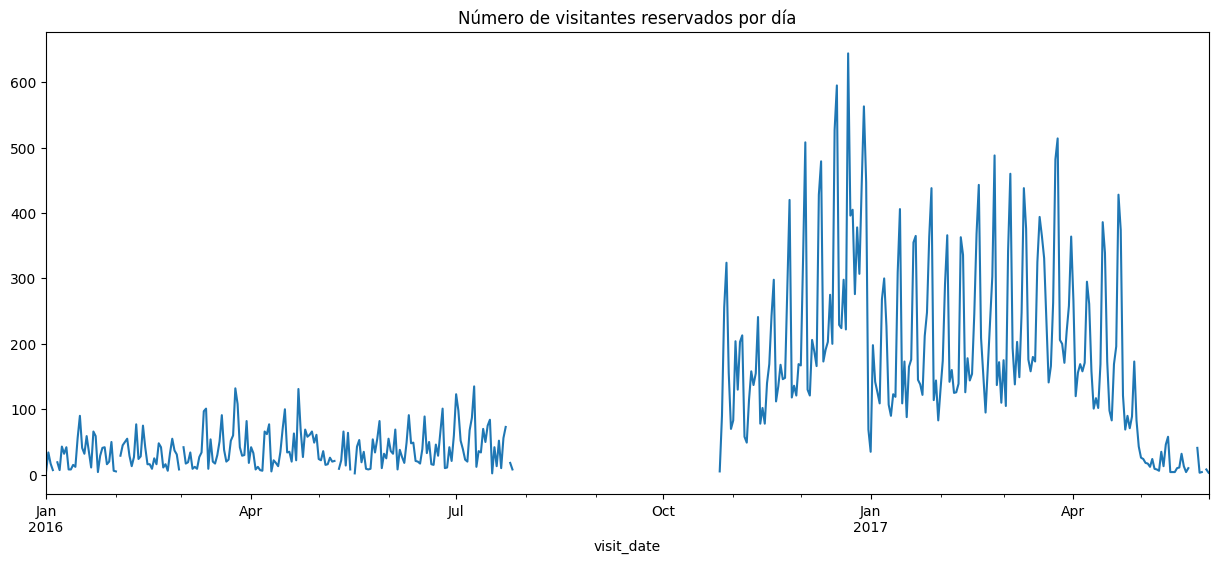

In [6]:
df_plot = df_by_day[["visit_date", "reserve_visitors"]].copy()
df_plot.set_index("visit_date", inplace=True)

df_plot.plot(figsize=(15, 6), title="Número de visitantes reservados por día", legend=False)

plt.show()

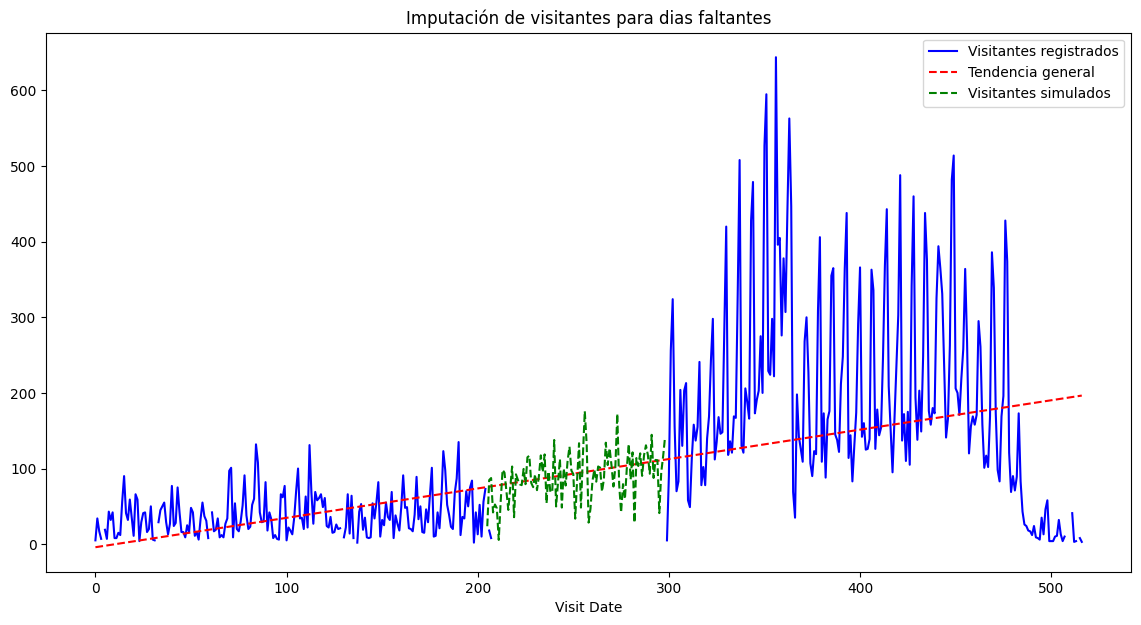

In [10]:
df_reg = df_by_day[df_by_day['visit_date'] < '2016-07-24'].copy()

df_reg = df_by_day.copy()
df_reg["reserve_visitors"] = df_reg["reserve_visitors"].fillna(method="ffill")

#linear regression 
from sklearn.linear_model import LinearRegression

X = df_reg["index"].values.reshape(-1, 1)  # Reshape for sklearn
y = df_reg['reserve_visitors'].values

model = LinearRegression()
model.fit(X, y)

# Predicción
y_pred = model.predict(X)
#y_pred_more = model.predict(np.array(range(205, 1000)).reshape(-1, 1))
df_reg['predicted_visitors'] = y_pred

df_by_day_std = df_by_day[df_by_day['visit_date'] < '2016-07-24']["reserve_visitors"].std()

preds = []
for i in range(205, 299):
    preds.append(float(np.random.normal(loc=model.predict(np.array([[i]])), scale=df_by_day_std, size=1)[0]))

# plot
plt.figure(figsize=(14, 7))
plt.plot(df_by_day['index'], df_by_day['reserve_visitors'], label='Actual Visitors', color='blue')
plt.plot(df_reg['index'], df_reg['predicted_visitors'], label='Predicted Visitors', color='red', linestyle='--')
plt.plot(range(205, 299), preds, label='Future Predictions', color='green', linestyle='--')

plt.legend(labels=['Visitantes registrados', 'Tendencia general', 'Visitantes simulados'])
plt.title('Imputación de visitantes para dias faltantes')
plt.xlabel('Visit Date')

plt.show()

In [165]:
#input values
df_by_day_new = df_by_day.copy()

for i in range(205, 299):
    df_by_day_new.loc[i, 'reserve_visitors'] = preds[i - 205]

df_by_day_new["reserve_visitors"] = df_by_day_new["reserve_visitors"].fillna(method="ffill")

df_by_day_new["visit_date"] = pd.to_datetime(df_by_day_new["visit_date"])
df_by_day_new = df_by_day_new[["visit_date", "reserve_visitors"]].set_index('visit_date')



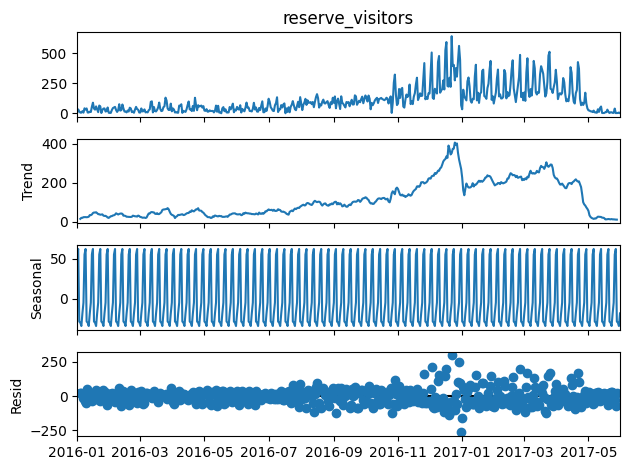

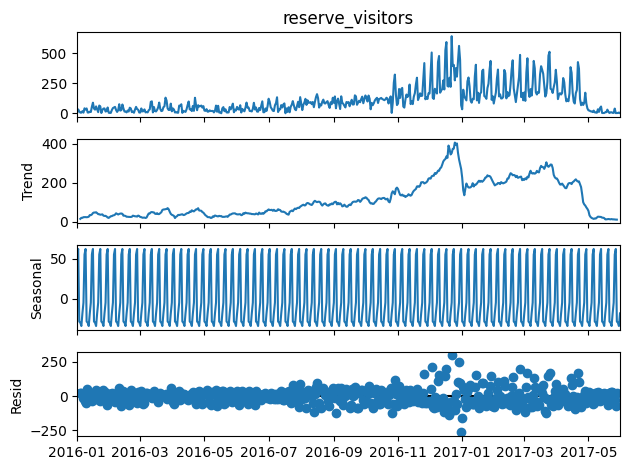

In [166]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_serie = df_by_day_new.copy()

resultado = seasonal_decompose(df_serie["reserve_visitors"], model='additive', period=7)
resultado.plot()

In [185]:

product_orders = product(
    [0, 1, 2],  # p
    [0, 1],     # d
    [0, 1, 2],  # q
    [0, 1],     # P
    [0, 1],     # D
    [0, 1, 2],  # Q
    [7]         # s (seasonal period)
)

results = []

for order in tqdm(product_orders):
    p, d, q, P, D, Q, s = order
    try:
        modelo = SARIMAX(df_serie['reserve_visitors'], order=(p, d, q), seasonal_order=(P, D, Q, s))
        resultado = modelo.fit(disp=False)
        results.append((order, resultado.aic))
        #print(f"Order: {order}, AIC: {resultado.aic}")
    except Exception as e:
        print(f"Order: {order} failed with error: {e}")

#modelo = SARIMAX(df_serie['reserve_visitors'], order=(1,0,1), seasonal_order=(1,1,1,7))  # asumiendo patrón semanal
#resultado = modelo.fit()

#print(resultado.summary())

216it [00:52,  4.10it/s]


In [187]:
results = pd.DataFrame(results, columns=['Order', 'AIC'])
results = results.sort_values(by='AIC')

In [192]:
modelo = SARIMAX(df_serie['reserve_visitors'], order=(1,0,1), seasonal_order=(1,1,1,7))  # asumiendo patrón semanal
resultado = modelo.fit()

print(resultado.summary())

                                     SARIMAX Results                                     
Dep. Variable:                  reserve_visitors   No. Observations:                  517
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -2777.247
Date:                           Wed, 04 Jun 2025   AIC                           5564.494
Time:                                   01:44:20   BIC                           5585.666
Sample:                               01-01-2016   HQIC                          5572.795
                                    - 05-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9274      0.016     57.933      0.000       0.896       0.959
ma.L1         -0.6792      0.029    -23.489

In [193]:
# Forecast de los próximos 30 días
n_periods = 180
forecast = resultado.get_forecast(steps=n_periods)

# Valores predichos
pred = forecast.predicted_mean

# Intervalo de confianza
conf_int = forecast.conf_int()

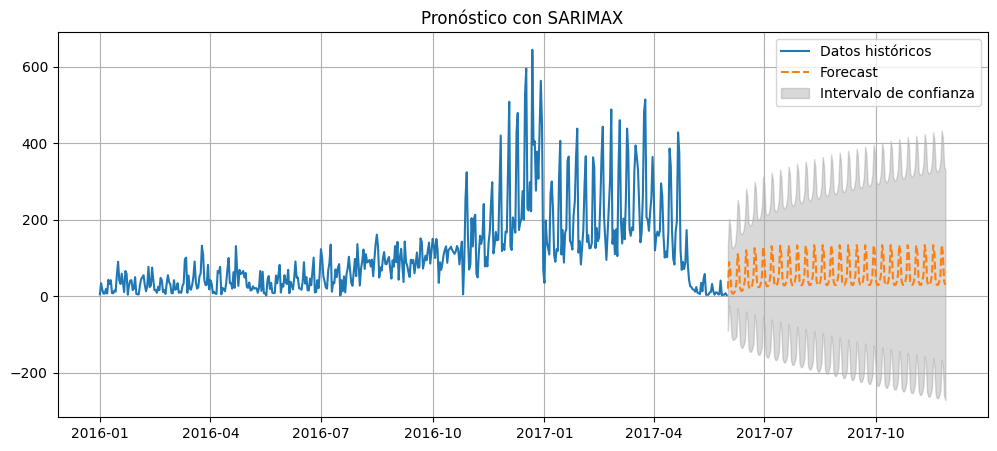

In [194]:
import matplotlib.pyplot as plt

# Crear fechas futuras para el forecast
fechas_forecast = pd.date_range(df_serie.index[-1] + pd.Timedelta(days=1), periods=n_periods)

# Reindexar las predicciones e intervalos
pred.index = fechas_forecast
conf_int.index = fechas_forecast

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(df_serie['reserve_visitors'], label='Datos históricos')
plt.plot(pred, label='Forecast', linestyle='--')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='gray', alpha=0.3, label='Intervalo de confianza')
plt.title('Pronóstico con SARIMAX')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train = pd.DataFrame(df_serie['reserve_visitors'][:-30])  # Todos menos los últimos 30 días
test = pd.DataFrame(df_serie['reserve_visitors'][-30:])   # Los últimos 30 días como prueba

modelo = SARIMAX(train['reserve_visitors'], order=(1,0,1), seasonal_order=(1,1,1,7))  # asumiendo patrón semanal
resultado = modelo.fit()

forecast = resultado.get_forecast(steps=30)
pred = forecast.predicted_mean

MAE:  110.62
RMSE: 134.09
MAPE: 1388.71%


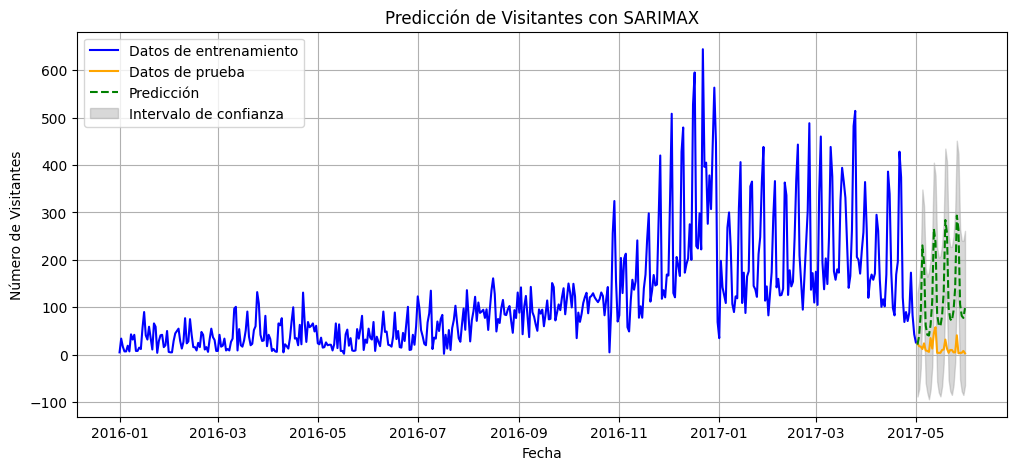

In [223]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(test, pred)
rmse = root_mean_squared_error(test, pred)  # raíz del MSE
mape = (abs((test.values.flatten() - pred.values) / test.values.flatten())).mean() * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Graficar los resultados
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['reserve_visitors'], label='Datos de entrenamiento', color='blue')
plt.plot(test.index, test['reserve_visitors'], label='Datos de prueba', color='orange')
plt.plot(pred.index, pred, label='Predicción', color='green', linestyle='--')
plt.fill_between(pred.index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1],
                 color='gray', alpha=0.3, label='Intervalo de confianza')
plt.title('Predicción de Visitantes con SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Número de Visitantes')
plt.legend()
plt.grid(True)
plt.show()


# AQUI ACABA EL EJERCICIO PRINCIPAL


In [77]:
df_by_day["weekday"] = pd.to_datetime(df_by_day["visit_date"]).dt.weekday

In [132]:
#df_serie = df_by_day[df_by_day['visit_date'] <= '2016-10-25']
df_serie = df_by_day[df_by_day['visit_date'] <'2016-07-24']


df_serie["reserve_visitors"] = df_serie["reserve_visitors"].fillna(method="ffill") 

df_serie["visit_datetime"] = pd.to_datetime(df_serie["visit_date"])
df_serie = df_serie[["visit_datetime", "reserve_visitors"]].set_index("visit_datetime")


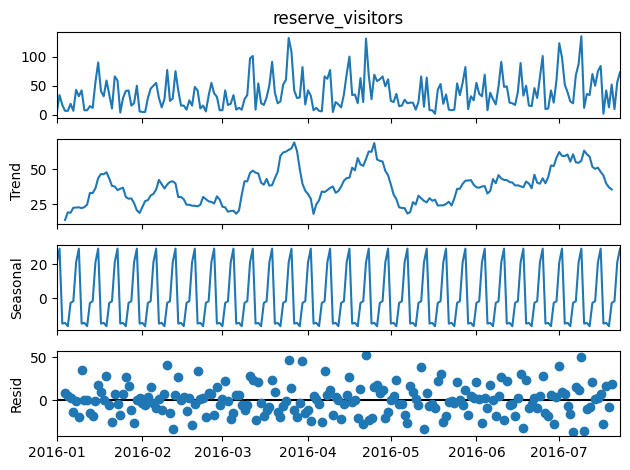

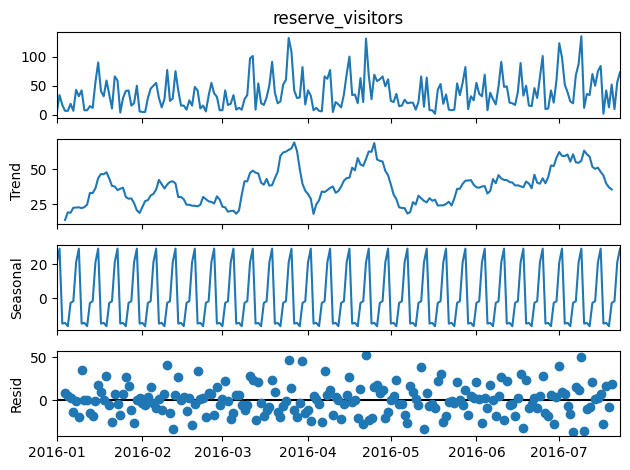

In [133]:
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df_serie["reserve_visitors"], model='additive', period=7)
resultado.plot()

In [158]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
modelo = SARIMAX(df_serie['reserve_visitors'], order=(0,0,1), seasonal_order=(1,1,1,7))  # asumiendo patrón semanal
resultado = modelo.fit()

/opt/anaconda3/envs/maestria_ia/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/maestria_ia/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [159]:
print(resultado.summary())

                                     SARIMAX Results                                     
Dep. Variable:                  reserve_visitors   No. Observations:                  205
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 7)   Log Likelihood                -904.385
Date:                           Wed, 04 Jun 2025   AIC                           1816.769
Time:                                   01:35:15   BIC                           1829.922
Sample:                               01-01-2016   HQIC                          1822.093
                                    - 07-23-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1837      0.068      2.713      0.007       0.051       0.316
ar.S.L7        0.1517      0.086      1.760

In [160]:
# Forecast de los próximos 30 días
n_periods = 180
forecast = resultado.get_forecast(steps=n_periods)

# Valores predichos
pred = forecast.predicted_mean

# Intervalo de confianza
conf_int = forecast.conf_int()

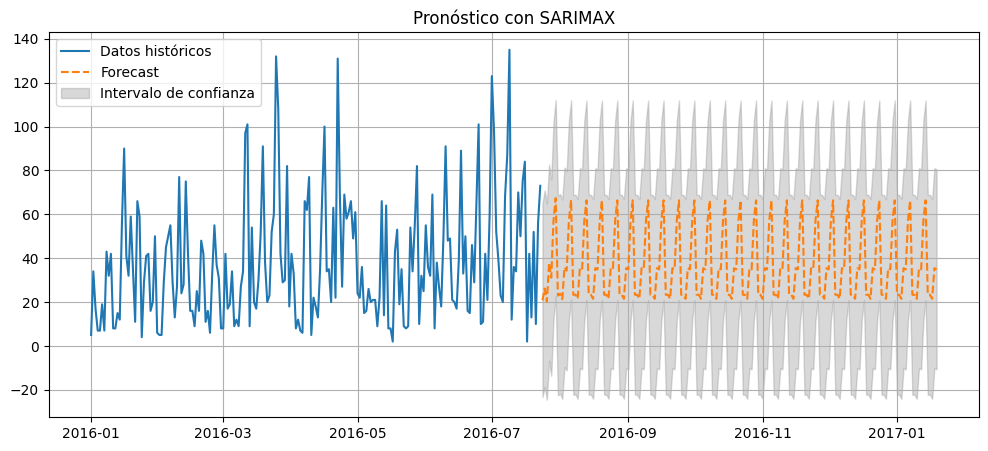

In [161]:
import matplotlib.pyplot as plt

# Crear fechas futuras para el forecast
fechas_forecast = pd.date_range(df_serie.index[-1] + pd.Timedelta(days=1), periods=n_periods)

# Reindexar las predicciones e intervalos
pred.index = fechas_forecast
conf_int.index = fechas_forecast

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(df_serie['reserve_visitors'], label='Datos históricos')
plt.plot(pred, label='Forecast', linestyle='--')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='gray', alpha=0.3, label='Intervalo de confianza')
plt.title('Pronóstico con SARIMAX')
plt.legend()
plt.grid(True)
plt.show()